### 데이터셋 임포트하기

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

import os

# for local execution
current_dir = os.path.abspath('.')
dataset_dir = os.path.join(os.path.abspath(current_dir + "/../"), 'dataset_kaggle_IEEE_CIS_Fraud_Detection')
print(os.listdir(dataset_dir))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [2]:
# 데이터 로딩(for Kaggle Kernel)
# train_tran = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
# train_iden = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
# test_tran = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
# test_iden = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')
# sample_sub = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

# 데이터 로딩 (for local execution)
train_tran = pd.read_csv(os.path.join(dataset_dir, 'train_transaction.csv'), index_col='TransactionID')
train_iden = pd.read_csv(os.path.join(dataset_dir, 'train_identity.csv'), index_col='TransactionID')
test_tran = pd.read_csv(os.path.join(dataset_dir, 'test_transaction.csv'), index_col='TransactionID')
test_iden = pd.read_csv(os.path.join(dataset_dir, 'test_identity.csv'), index_col='TransactionID')
sample_sub = pd.read_csv(os.path.join(dataset_dir, 'sample_submission.csv'), index_col='TransactionID')

Train과 Test 데이터는 모두 각각 Identity와 Transaction 두 개의 .csv파일로 나뉘어 있습니다. 이는 'TransactionID'라는 column으로 join되어 있습니다. 단, `train_identity.csv`와 `train_transaction.csv`의 모든 거래 내역(transactions)들이 서로 완벽히 일치하지는 않습니다. 

* <b>`train_transaction.csv`의 범주형 번수</b>
    * TransactionID : reference datetime(실제 timestamp와 다름)으로부터의 timedelta(시간변화량)을 의미
    * TransactionAmt : USD를 이용해 지불된 거래 금액
    * ProductCD : 제품 code(각 거래마다의 제품 코드)
    * card1 ~ card6 : 거래에 사용한 카드 정보(카드 타입, 카드 카테고리, 카드 발행은행, 국가 등)
    * addr1 ~ addr2 : 주소
    * dist : 거리(distance)
    * P_emaildomain, R_emaildomain : 구매자 및 수신자 이메일 도메인 주소
    * C1 ~ C14 : 얼마나 많은 주소가 지불 카드와 관련있는지에 대한 횟수(counting)로, 실제 의미는 비식별 처리되어(masked)있음.
    * D1 ~ D15 : 이전 거래일과의 시간변화량(timedelta)
    * M1 ~ M9 : 카드에 적힌 이름이나 주소 등등이 일치하는지 여부


* <b>`train_identity.csv`의 범주형 변수</b>
    * DeviceType
    * DeviceInfo
    * id_12 ~ id_38 : 트랜잭션과 관련된 식별 정보 (네트워크 연결 정보 - IP, ISP, Proxy 등) 및 디지털 서명(UA/browser/OS/version 등)을 의미하며, Vesta의 사기 방지 시스템 및 디지털 보안 파트너사가 함께 수집했습니다. 필드의 이름들은 개인정보 보호를 위해 비식별 처리되어 있습니다. 
   
이번 대회의 데이터는 메모리 문제를 유발할 수 있기 때문에, Memory reduce를 진행하여야 합니다. 불러오는 것은 물론 처리에도 시간이 많이 소비되므로, 메모리 사용량을 줄여 보겠습니다. 이번 대회의 데이터 타입들은 대부분 int64, float64로 이루어져 있으며, 실제 데이터는 int64 타입이지만 실질적인 데이터 범위가 int16에만 속한다면 메모리를 줄이는 것이 효율적일 것입니다. (https://hwiyong.tistory.com/238 참고)

In [3]:
## Dataframe의 메모리 사이즈를 줄이기 위한 함수
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## REducing memory
train_tran = reduce_mem_usage(train_tran)
train_iden = reduce_mem_usage(train_iden)
test_tran = reduce_mem_usage(test_tran)
test_iden = reduce_mem_usage(test_iden)

Mem. usage decreased to 544.60 Mb (69.3% reduction)
Mem. usage decreased to 26.41 Mb (41.5% reduction)
Mem. usage decreased to 474.52 Mb (68.8% reduction)
Mem. usage decreased to 25.98 Mb (41.5% reduction)


In [4]:
# Join training datasets
train = train_tran.merge(train_iden, how='left',left_index=True, right_index=True)
print(train.shape)

# Join testing datasets
test = test_tran.merge(test_iden, how='left',left_index=True, right_index=True)
print(test.shape)

(590540, 433)
(506691, 432)


In [5]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
test.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# get target feature
y_train = train['isFraud'].copy()
print(y_train.shape)

# get features matrices
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()
print(X_test.shape)

# Free memory
del test, train_tran, train_iden, test_tran, test_iden
print('test, train_tran, train_iden, test_tran, test_iden has been removed.')

(590540,)
(506691, 432)
test, train_tran, train_iden, test_tran, test_iden has been removed.


In [12]:
y_train.head()

TransactionID
2987000    0
2987001    0
2987002    0
2987003    0
2987004    0
Name: isFraud, dtype: int8

In [13]:
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [14]:
X_test.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explore Data 
첫번째로 Train과 Test 데이터에 대한 time series 분할을 해볼 것입니다. `TransactionDT` feature는 주어진 참조 시간(reference datetime, 현실의 시간과 다름)에 대한 시간 변화량(timedelta)입니다. train과 test 데이터가 시간에 따라 분리되어 있으며, 두 데이터셋 사이에 약간 간격이 존재하는 것을 확인할 수 있습니다. 이는 추후 CV(Cross validation)기법을 사용해야 하는지에 대한 여부 결정에 영향을 미칩니다. 이제 다른 train, test의 feature들에 대해서도 분석해 보겠습니다.


#### 시간변화에 따른 분포 확인해보기

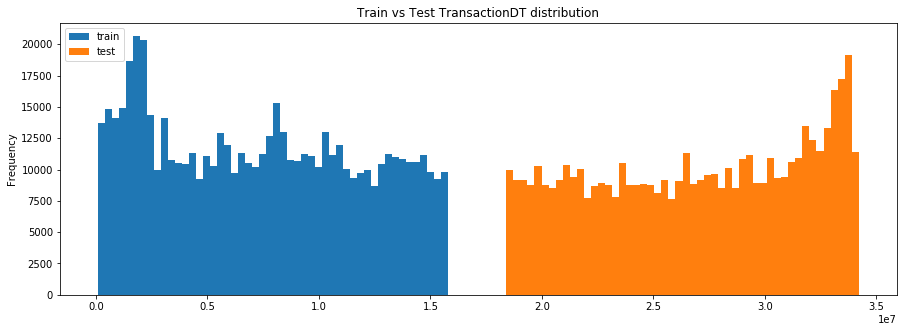

In [15]:
X_train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
X_test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

#### isFraud, ProductCD, DeviceType의 횟수 비교해보기
isFraud에 대해 매우 불균형적인 target값을 갖고 있으며, 구입한 제품의 종류 또한 불균형한것을 확인할 수 있습니다. 또한 대부분의 거래들이 desktop환경에서 이루어졌음을 알 수 있습니다.

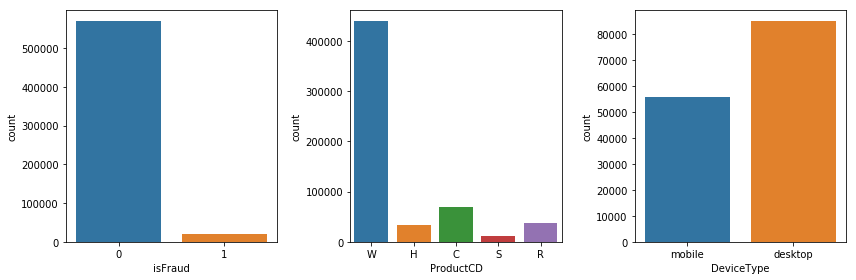

In [21]:
f, axes = plt.subplots(1, 3, figsize=(12, 4))
isFraud = sns.countplot(x='isFraud', data=train, ax=axes[0])
ProductCD = sns.countplot(x='ProductCD', data=train, ax=axes[1])
DeviceType = sns.countplot(x='DeviceType', data=train, ax=axes[2])
plt.tight_layout()

#### DeviceInfo plot 그려보기

In [1]:
# DeviceCount, DeviceInfo 두 개의 열을 갖는 DF를 만듭니다.
group = pd.DataFrame()
group['DeviceCount'] = train.groupby(['DeviceInfo'])['DeviceInfo'].count()
group['DeviceInfo'] = group.index

# top 30개 Device들에 대해 sort합니다. 
group_top = group.sort_values(by='DeviceCount',ascending=False).head(30)

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x="DeviceInfo", y="DeviceCount", data=group_top)
xt = plt.xticks(rotation=60)

NameError: name 'pd' is not defined